# Demand prediction for theme parks (specific case of USS)

In [3]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import simpy
from datetime import datetime, timedelta
import os
os.chdir("C:/Users/parma/data-science-guest-experience/data-science-guest-experience/Scripts/Subgroup_B")

## Loading datasets
### Load survey data	
Purpose:
Loads and processes a survey dataset to prepare it for further analysis or modeling. The function handles renaming columns, standardizing attraction names, mapping wait time categories, normalizing satisfaction scores, and creating synthetic data for long wait attractions. It also infers the visitor's season of visit and assigns synthetic events.

Arguments:
file_path (str): Path to the CSV file containing the survey data (default: "../../data/survey.csv").

Returns:
pd.DataFrame: A cleaned and processed DataFrame ready for further analysis or modeling. The resulting DataFrame includes columns like Favorite_Attraction, Avg_Wait_Time, Satisfaction_Score, Age_Group, Employment_Status, Visit_Quarter, and others, with appropriate transformations applied.

Function Overview:
1. Rename Columns: Renames survey columns to standardized and more intuitive names for easier analysis.
2. Map Attractions to Standardized Names: The function maps the names of attractions mentioned in the dataset to a consistent naming scheme using a predefined dictionary.
3. Map Wait Time Categories: Converts textual wait time categories (e.g., "Less than 15 minutes") to numeric values representing the average wait times.
4. Normalize Satisfaction Scores: Normalizes the satisfaction score column to a range between 0 and 1 for easier comparison and modeling.
5. Infer Season of Visit: Maps the textual representation of the visitor's season of visit to quarterly time buckets (e.g., "Jan-Mar", "Apr-Jun").
6. Assign Synthetic Event Data: Adds a synthetic Event column, randomly assigning either "None" or "Special Event" with predefined probabilities (80% "None", 20% "Special Event").
7. Explode Long Wait Attractions: For visitors who mentioned having experienced long wait times, this step creates new rows for each attraction they encountered, assigning random wait times between 75-105 minutes.
8. Select and Return Final Columns: The function then selects the most relevant columns for analysis and combines the original dataset with the newly created data for long wait attractions.

In [4]:
def load_survey_data(file_path="../../data/survey.csv"):

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} not found. Please provide the survey dataset.")

    df = pd.read_csv(file_path)

    # Step 1: Rename columns if they exist
    rename_map = {
        "Which age group do you belong to?": "Age_Group",
        "What is your employment status?": "Employment_Status",
        "Which part of the year did you visit USS?": "Visit_Season",
        "Which ride or attraction was your favourite?": "Favorite_Attraction",
        "Why this attraction in particular? ": "Attraction_Reason",
        "Did you experience any rides with longer-than-expected wait times? If yes, which ride(s)?": "Long_Wait_Attractions",
        "How long did you wait in line for rides on average during your visit?": "Avg_Wait_Time",
        "On a scale of 1-5, how would you rate your overall experience at USS?": "Satisfaction_Score"
    }
    df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

    # Step 2: Map attractions to standardize names
    attraction_map = {
        "CYLON": "Battlestar Galactica: CYLON",
        "HUMAN": "Battlestar Galactica: HUMAN",
        "Transformers": "Transformers: The Ride",
        "Revenge of the Mummy": "Revenge of the Mummy",
        "Sesame Street Spaghetti Space Chase": "Sesame Street Spaghetti Space Chase",
        "Puss in Boots": "Puss In Boots' Giant Journey",
        "Canopy Flyer": "Canopy Flyer",
        "Treasure Hunters": "Treasure Hunters"
    }

    # Map attractions in 'Favorite_Attraction'
    if 'Favorite_Attraction' in df.columns:
        df['Favorite_Attraction'] = df['Favorite_Attraction'].apply(lambda x: attraction_map.get(x, x))

    # Map attractions in 'Long_Wait_Attractions' (if available)
    if 'Long_Wait_Attractions' in df.columns:
        df['Long_Wait_Attractions'] = df['Long_Wait_Attractions'].apply(lambda x: [attraction_map.get(a, a) for a in x.split(", ")] if isinstance(x, str) else x)

    df.reset_index(drop=True, inplace=True)

    # Step 3: Map wait time categories
    wait_time_map = {
        "Less than 15 minutes": 10,
        "15 to 30 minutes": 22.5,
        "31 to 45 minutes": 37.5,
        "46 to 60 minutes": 52.5,
        "61 to 90 minutes": 75,
        "More than 90 minutes" : 100
    }
    if "Avg_Wait_Time" in df.columns:
        df["Avg_Wait_Time"] = df["Avg_Wait_Time"].map(wait_time_map).fillna(37.5)
    else:
        df["Avg_Wait_Time"] = 37.5

    # Step 4: Normalize satisfaction score
    df["Satisfaction_Score"] = pd.to_numeric(df.get("Satisfaction_Score", 3), errors="coerce")
    df["Satisfaction_Score"] = (
        (df["Satisfaction_Score"] - df["Satisfaction_Score"].min()) /
        (df["Satisfaction_Score"].max() - df["Satisfaction_Score"].min())
    )

    # Step 5: Convert fuzzy seasons into quarterly buckets
    def infer_season(val):
        if pd.isna(val) or val.strip().lower() == "can't recall / not sure":
            return np.random.choice(["Jan-Mar", "Apr-Jun", "Jul-Sep", "Oct-Dec"], p=[0.1, 0.1, 0.6, 0.2])
        val = val.lower()
        if any(month in val for month in ["jan", "feb", "mar"]):
            return "Jan-Mar"
        elif any(month in val for month in ["apr", "may", "jun"]):
            return "Apr-Jun"
        elif any(month in val for month in ["jul", "aug", "sep"]):
            return "Jul-Sep"
        elif any(month in val for month in ["oct", "nov", "dec"]):
            return "Oct-Dec"
        return "Jul-Sep"

    df["Visit_Quarter"] = df.get("Visit_Season", "Jul-Sep").apply(infer_season)

    # Step 6: Assign synthetic event
    np.random.seed(42)
    df["Event"] = np.random.choice(["None", "Special Event"], size=len(df), p=[0.8, 0.2])

    # Step 7: Explode long wait attractions
    long_wait_df = pd.DataFrame()
    if "Long_Wait_Attractions" in df.columns:
        exploded = df["Long_Wait_Attractions"].dropna().str.split(", ", expand=True).stack().reset_index()
        exploded.columns = ['original_index', 'split_index', 'Attraction']
        exploded = exploded[exploded['Attraction'].notna()]

        wait_times = [75 + np.random.randint(0, 31) for _ in range(len(exploded))]

        def safe_get(col, default=None):
            return df[col].iloc[exploded["original_index"]].values if col in df.columns else [default] * len(exploded)

        long_wait_df = pd.DataFrame({
            "Favorite_Attraction": exploded["Attraction"],
            "Avg_Wait_Time": wait_times,
            "Satisfaction_Score": safe_get("Satisfaction_Score"),
            "Age_Group": safe_get("Age_Group"),
            "Employment_Status": safe_get("Employment_Status"),
            "Visit_Quarter": safe_get("Visit_Quarter", "Jul-Sep"),
            "Event": safe_get("Event", "None"),
            "Attraction_Reason": safe_get("Attraction_Reason")
        })

    # Step 8: Select final columns to keep
    base_columns = [
        "Favorite_Attraction", "Avg_Wait_Time", "Satisfaction_Score", "Age_Group",
        "Employment_Status", "Visit_Quarter", "Event"
    ]
    if "Attraction_Reason" in df.columns:
        base_columns.append("Attraction_Reason")

    base_df = df[base_columns].copy()
    df_combined = pd.concat([base_df, long_wait_df], ignore_index=True)

    return df_combined


In [5]:
# Load survey data and apply standardization
df_survey = load_survey_data()
print(df_survey.head())

                   Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  \
0          Battlestar Galactica: HUMAN          100.0                0.75   
1          Battlestar Galactica: HUMAN           52.5                0.75   
2               Transformers: The Ride           37.5                0.75   
3          Battlestar Galactica: CYLON           52.5                0.75   
4  Sesame Street Spaghetti Space Chase           22.5                0.50   

           Age_Group Employment_Status Visit_Quarter          Event  \
0  25 - 34 years old          Employed       Oct-Dec           None   
1  18 - 24 years old           Student       Apr-Jun  Special Event   
2  18 - 24 years old           Student       Oct-Dec           None   
3  18 - 24 years old           Student       Oct-Dec           None   
4  18 - 24 years old           Student       Oct-Dec           None   

                                   Attraction_Reason  
0                                     Very exciting!  


Generating more survey data using SDV since sample size is too small. 

In [6]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(
    data=df_survey)

from sdv.single_table import GaussianCopulaSynthesizer

# Step 1: Create the synthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)

# Step 2: Train the synthesizer
synthesizer.fit(df_survey)

# Step 3: Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)
combined_survey_df = pd.concat([df_survey, synthetic_data], ignore_index=True)
print(combined_survey_df.head())

c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


                   Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  \
0          Battlestar Galactica: HUMAN          100.0                0.75   
1          Battlestar Galactica: HUMAN           52.5                0.75   
2               Transformers: The Ride           37.5                0.75   
3          Battlestar Galactica: CYLON           52.5                0.75   
4  Sesame Street Spaghetti Space Chase           22.5                0.50   

           Age_Group Employment_Status Visit_Quarter          Event  \
0  25 - 34 years old          Employed       Oct-Dec           None   
1  18 - 24 years old           Student       Apr-Jun  Special Event   
2  18 - 24 years old           Student       Oct-Dec           None   
3  18 - 24 years old           Student       Oct-Dec           None   
4  18 - 24 years old           Student       Oct-Dec           None   

                                   Attraction_Reason  
0                                     Very exciting!  


## Load IoT data

Purpose:
Loads and preprocesses synthetic IoT data to prepare it for further analysis or modeling. The function handles the following preprocessing steps:
- Converts date columns to datetime format.
- Flags weekend visits.
- Flags visits to popular attractions.
- Expands the "Attraction_Times" data into individual records for each attraction visited.

Arguments:
file_path (str): Path to the synthetic IoT CSV file. Default is "../../data/synthetic_iot_data_v3.csv".

Returns:
pd.DataFrame: A cleaned and enriched DataFrame that includes detailed information about the visitor's attractions, including:

- Date: Date of the visit.
- Loyalty_Member: Whether the visitor is a loyalty member ("Yes" or "No").
- Age: Age of the visitor.
- Theme_Zone_Visited: Zones of the theme park visited by the visitor.
- Attraction: Name of the visited attraction.
- Check_In: Time when the visitor checked into the attraction.
- Queue_Time: Time spent in the queue for the attraction.
- Check_Out: Time when the visitor checked out of the attraction.
- Average_Queue_Time: The average queue time for the visitor across all visited attractions.
- Restaurant_Spending: The amount spent on food and beverages.
- Merchandise_Spending: The amount spent on merchandise.
- Total_Spending: The total spending (restaurant + merchandise).
- Day_of_Week: Day of the week when the visit occurred.
- Is_Weekend: Flag indicating whether the visit occurred on a weekend.
- Is_Popular_Attraction: Flag indicating whether the visited attraction is considered "popular."

In [7]:
import os
import pandas as pd

def load_iot_data(file_path="../../data/synthetic_iot_data_v3.csv"):
    """
    Loads and preprocesses synthetic IoT data for analysis or modeling.

    Args:
        file_path (str): Path to the synthetic IoT CSV file.

    Returns:
        pd.DataFrame: Cleaned and enriched IoT data.
    """
    if not os.path.exists(file_path):
        print(f"Warning: IoT data file {file_path} not found. Skipping IoT data integration.")
        return None

    # Load data
    df_iot = pd.read_csv(file_path)

    # Convert 'Date' to datetime
    df_iot['Date'] = pd.to_datetime(df_iot['Date'])

    # Extract day of the week
    df_iot['Day_of_Week'] = df_iot['Date'].dt.day_name()

    # Flag for weekend visits
    df_iot['Is_Weekend'] = df_iot['Day_of_Week'].isin(["Saturday", "Sunday"])

    # Define popular attractions
    POPULAR_ATTRACTIONS = {
        "Revenge of the Mummy",
        "Battlestar Galactica: CYLON",
        "Transformers: The Ride",
        "Battlestar Galactica: HUMAN",
        "Sesame Street Spaghetti Space Chase"
    }

    # Add flag if any visited attraction is popular
    df_iot['Is_Popular_Attraction'] = df_iot['Attraction_Times'].apply(
        lambda x: any(attraction['Attraction'] in x for attraction in eval(x))  # Use eval to convert string to list of dicts
    )

    # Function to process the Attraction_Times
    def process_attraction_times(attraction_times):
        """
        Processes the attraction times to extract check-in, queue, and check-out times.
        """
        attractions_data = []

        # Convert the string representation of the list to a list of dictionaries
        attractions = eval(attraction_times)  # Safely converts stringified list into actual list of dictionaries
        for attraction in attractions:
            attractions_data.append({
                "Attraction": attraction['Attraction'],
                "Check_In": attraction['Check_In'],
                "Queue_Time": attraction['Queue_Time'],
                "Check_Out": attraction['Check_Out']
            })
        return attractions_data

    # Apply the processing function to each row in the 'Attraction_Times' column
    df_iot['Processed_Attraction_Times'] = df_iot['Attraction_Times'].apply(process_attraction_times)

    # Now you can expand the Processed_Attraction_Times list into separate rows, if necessary
    # This will create a separate row for each attraction visited
    df_iot_expanded = df_iot.explode('Processed_Attraction_Times', ignore_index=True)

    # Extract individual columns from the expanded 'Processed_Attraction_Times' list
    df_iot_expanded['Attraction'] = df_iot_expanded['Processed_Attraction_Times'].apply(lambda x: x['Attraction'])
    df_iot_expanded['Check_In'] = df_iot_expanded['Processed_Attraction_Times'].apply(lambda x: x['Check_In'])
    df_iot_expanded['Queue_Time'] = df_iot_expanded['Processed_Attraction_Times'].apply(lambda x: x['Queue_Time'])
    df_iot_expanded['Check_Out'] = df_iot_expanded['Processed_Attraction_Times'].apply(lambda x: x['Check_Out'])

    # Drop the 'Processed_Attraction_Times' column now that we've expanded it
    df_iot_expanded.drop(columns=['Processed_Attraction_Times'], inplace=True)

    # Select relevant columns based on your IoT dataset
    relevant_columns = [
        "Visitor_ID", "Date", "Loyalty_Member", "Age", "Gender", "Theme_Zone_Visited",
        "Attraction", "Check_In", "Queue_Time", "Check_Out", "Average_Queue_Time",
        "Restaurant_Spending", "Merchandise_Spending", "Total_Spending", "Day_of_Week", "Is_Weekend", "Is_Popular_Attraction"
    ]
    
    # Filter the dataframe to include only the relevant columns
    df_iot_expanded = df_iot_expanded[relevant_columns]

    return df_iot_expanded

# Example usage
df_iot = load_iot_data()
print(df_iot.head())


                             Visitor_ID       Date Loyalty_Member  Age Gender  \
0  bd40a3e8-e445-4e5a-9393-0cc1c198bbbb 2024-04-12            Yes    8   Male   
1  bd40a3e8-e445-4e5a-9393-0cc1c198bbbb 2024-04-12            Yes    8   Male   
2  bd40a3e8-e445-4e5a-9393-0cc1c198bbbb 2024-04-12            Yes    8   Male   
3  affcc925-7347-4e80-8dc4-57f9cb8e72c1 2024-02-20             No   61   Male   
4  affcc925-7347-4e80-8dc4-57f9cb8e72c1 2024-02-20             No   61   Male   

                                  Theme_Zone_Visited  \
0      ['New York', 'Ancient Egypt', 'Far Far Away']   
1      ['New York', 'Ancient Egypt', 'Far Far Away']   
2      ['New York', 'Ancient Egypt', 'Far Far Away']   
3  ['Hollywood', 'New York', 'Sci-Fi City', 'The ...   
4  ['Hollywood', 'New York', 'Sci-Fi City', 'The ...   

                            Attraction  Check_In  Queue_Time  Check_Out  \
0  Sesame Street Spaghetti Space Chase     11.00       10.41      11.42   
1                 Revenge 

### Checking which features are important to predict demand for IOT data
Using random forest to find features that correlate to the number of people in queue, which are the weather conditions, guest satisfaction score, and average queue time. 

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define popular attractions
POPULAR_ATTRACTIONS = {"Revenge of the Mummy", "Battlestar Galactica: CYLON", "Transformers: The Ride", "Battlestar Galactica: HUMAN"}

# Add flag if any visited attraction is popular
df_iot['Is_Popular_Attraction'] = df_iot['Attraction'].apply(
    lambda x: any(attraction in str(x) for attraction in POPULAR_ATTRACTIONS)
)

# Convert boolean columns to integers for modeling
df_iot['Is_Weekend'] = df_iot['Day_of_Week'].isin(["Saturday", "Sunday"]).astype(int)
df_iot['Is_Popular_Attraction'] = df_iot['Is_Popular_Attraction'].astype(int)

# Encode 'Theme_Zone_Visited' using Label Encoding
le = LabelEncoder()
df_iot['Theme_Zone_Visited'] = le.fit_transform(df_iot['Theme_Zone_Visited'])

# Encode 'Loyalty_Member' as 1 for 'Yes', 0 for 'No' (since it's a categorical feature)
df_iot['Loyalty_Member'] = df_iot['Loyalty_Member'].apply(lambda x: 1 if x == 'Yes' else 0)

# Encode 'Gender' as 1 (Female), 0 (Male) for simplicity
df_iot['Gender'] = df_iot['Gender'].apply(lambda x: 1 if x == 'Female' else 0)

# Features selection based on the available columns in df_iot
features = [
    'Age', 
    'Gender', 
    'Theme_Zone_Visited', 
    'Is_Weekend', 
    'Is_Popular_Attraction',
    'Restaurant_Spending',  # Include spending for the model
    'Merchandise_Spending',  # Merchandise spending might influence queue times
    'Check_In',  # Add Check_In as a feature (it might influence queue time)
    'Queue_Time'  # Queue time might also be a relevant feature for prediction
]

# Target variable: 'Average_Queue_Time'
X = df_iot[features]
y = df_iot['Average_Queue_Time']

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

# Print the feature importances
print("Feature Importance:\n")
print(feature_importance)

Feature Importance:

Queue_Time               0.414244
Check_In                 0.266782
Theme_Zone_Visited       0.109115
Age                      0.072619
Restaurant_Spending      0.053726
Merchandise_Spending     0.038831
Is_Popular_Attraction    0.024315
Gender                   0.010804
Is_Weekend               0.009565
dtype: float64


## Load weather data
Fetches or loads monthly weather data from Singapore’s government open data API and aggregates it into seasonal averages to be used as input features in demand prediction models.

Purpose:
- Automates the process of downloading or loading historical monthly weather data for 2024.
- Maps each month to a seasonal category used in survey responses (e.g., "January - March").
- Outputs a clean dataset with average weather values per season.

In [9]:
def fetch_weather_data(file_path="../../data/singapore_seasonal_weather.csv"):
    """
    Fetches or loads seasonal weather data for all months of 2024,
    calculates seasonal averages, and saves the result for reuse.

    Returns:
        pd.DataFrame: Weather data averaged by season.
    """
    import os
    import requests
    import pandas as pd

    if os.path.exists(file_path):
        print(f"Loaded existing weather data from: {file_path}")
        return pd.read_csv(file_path)

    print("📡 Fetching weather data from API...")

    base_url = "https://api.data.gov.sg/v1/environment/"
    weather_types = ["rainfall", "air-temperature", "relative-humidity", "wind-speed"]
    months = [f"2024-{str(m).zfill(2)}-15" for m in range(1, 13)]
    month_names = [datetime.strptime(m, "%Y-%m-%d").strftime("%B") for m in months]

    all_data = []

    for date_str, month_name in zip(months, month_names):
        print(f"Fetching data for: {date_str}")
        daily_data = {"month": month_name}

        for weather_type in weather_types:
            url = f"{base_url}{weather_type}"
            params = {"date": date_str}
            response = requests.get(url, params=params)

            if response.status_code == 200:
                try:
                    data = response.json()
                    readings = data["items"][0]["readings"]
                    avg_value = sum(d["value"] for d in readings) / len(readings)
                    daily_data[weather_type] = avg_value
                except (KeyError, IndexError):
                    print(f"⚠️ Missing data for {weather_type} on {date_str}")
                    daily_data[weather_type] = None
            else:
                print(f"❌ Error fetching {weather_type} for {date_str}: {response.status_code}")
                daily_data[weather_type] = None

        all_data.append(daily_data)

    df = pd.DataFrame(all_data)

    # Map months to seasons
    month_to_season = {
        "January": "January - March", "February": "January - March", "March": "January - March",
        "April": "April - June", "May": "April - June", "June": "April - June",
        "July": "July - September", "August": "July - September", "September": "July - September",
        "October": "October - December", "November": "October - December", "December": "October - December"
    }
    df["Season"] = df["month"].map(month_to_season)

    # Average by season
    df_seasonal = df.groupby("Season").agg({
        "rainfall": "mean",
        "air-temperature": "mean",
        "relative-humidity": "mean",
        "wind-speed": "mean"
    }).reset_index()

    df_seasonal.rename(columns={
        "air-temperature": "air_temperature",
        "relative-humidity": "relative_humidity",
        "wind-speed": "wind_speed"
    }, inplace=True)

    # Save to disk
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    df_seasonal.to_csv(file_path, index=False)
    print(f"✅ Saved seasonal weather data to: {file_path}")

    return df_seasonal

In [10]:
df_weather = fetch_weather_data("../../data/singapore_seasonal_weather.csv")
print(df_weather.head())

Loaded existing weather data from: ../../data/singapore_seasonal_weather.csv
               Season  rainfall  air_temperature  relative_humidity  \
0        April - June  0.000000        27.910354          86.727778   
1     January - March  0.001093        27.134091          81.434444   
2    July - September  0.000000        27.970971          78.282112   
3  October - December  0.000000        27.033810          83.870873   

   wind_speed  
0    2.330833  
1    4.568889  
2    2.646852  
3    2.230736  


## Merging datasets
### Merging survey and weather data (to analyse the absence of IOT data to feed into the model)

Purpose:
Merges survey data with seasonal weather data, and appends IoT data if provided. The function combines three datasets: survey data, weather data, and optionally IoT data. It ensures that seasonal information from the survey and IoT data is aligned with the weather data for further analysis.

Arguments:
- survey_df (pd.DataFrame): The survey dataset, which must contain a 'Visit_Quarter' column indicating the quarter of the year when the visit occurred.
- weather_df (pd.DataFrame): Seasonal weather data that contains a 'Season' column. The weather data should be structured with seasonal weather attributes, such as temperature or humidity.
- iot_df (pd.DataFrame, optional): The IoT dataset (if available). It should contain a 'Season' column for season-based merging. If not provided, only the survey and weather data will be merged.

Returns:
A combined dataset that includes survey data, weather data, and optionally IoT data, merged based on the 'Season' column. The merged dataset preserves all relevant columns from the input datasets.

In [11]:
def merge_survey_weather_iot(survey_df, weather_df, iot_df=None):
    """
    Merges survey data with seasonal weather data, and appends IoT data if provided.
    
    Args:
        survey_df (pd.DataFrame): Survey data with a 'Visit_Quarter' column.
        weather_df (pd.DataFrame): Seasonal weather data with 'Season' column.
        iot_df (pd.DataFrame, optional): IoT data (should contain 'Season' column).

    Returns:
        pd.DataFrame: Combined dataset (survey + weather [+ iot if provided]).
    """
    # Map 'Visit_Quarter' to 'Season' based on the provided data
    quarter_to_season = {
        "Jan-Mar": "January - March",
        "Apr-Jun": "April - June",
        "Jul-Sep": "July - September",
        "Oct-Dec": "October - December",
    }
    survey_df['Season'] = survey_df['Visit_Quarter'].map(quarter_to_season)

    # Merge survey with weather data based on 'Season'
    merged_survey = pd.merge(survey_df, weather_df, on='Season', how='left')

    if iot_df is None:
        return merged_survey

    # Ensure 'Season' exists in IoT data
    if 'Season' not in iot_df.columns:
        print("⚠️ 'Season' column missing in IoT data. Assigning season synthetically...")
        if 'Date' in iot_df.columns:
            iot_df['Date'] = pd.to_datetime(iot_df['Date'])
            month_to_season = {
                1: "January - March", 2: "January - March", 3: "January - March",
                4: "April - June", 5: "April - June", 6: "April - June",
                7: "July - September", 8: "July - September", 9: "July - September",
                10: "October - December", 11: "October - December", 12: "October - December"
            }
            iot_df['Season'] = iot_df['Date'].dt.month.map(month_to_season)
        else:
            iot_df['Season'] = np.random.choice(
                ["January - March", "April - June", "July - September", "October - December"],
                size=len(iot_df),
                p=[0.1, 0.1, 0.4, 0.4]
            )

    # Rename 'average_queue_time' to 'avg_wait_time' in IoT data
    if 'Average_Queue_Time' in iot_df.columns:
        iot_df.rename(columns={'Average_Queue_Time': 'Avg_Wait_Time'}, inplace=True)

    # Merge IoT with weather based on 'Season'
    merged_iot = pd.merge(iot_df, weather_df, on='Season', how='left')

    # Append both datasets (not inner join, preserve all columns)
    combined = pd.concat([merged_survey, merged_iot], ignore_index=True, join='outer')

    return combined


#### Merged dataset without IOT data
To put into model later to check the effect of just survey and weather data on the accuracy of the model.

In [12]:
df_combined = merge_survey_weather_iot(combined_survey_df, df_weather)
print(df_combined)
print(df_combined.columns.tolist())
print(df_combined.dtypes)

                      Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  \
0             Battlestar Galactica: HUMAN          100.0                0.75   
1             Battlestar Galactica: HUMAN           52.5                0.75   
2                  Transformers: The Ride           37.5                0.75   
3             Battlestar Galactica: CYLON           52.5                0.75   
4     Sesame Street Spaghetti Space Chase           22.5                0.50   
...                                   ...            ...                 ...   
1205                 Revenge of the Mummy          100.0                0.55   
1206               Transformers: The Ride           22.7                0.44   
1207                 Revenge of the Mummy           22.5                0.88   
1208          Battlestar Galactica: CYLON           33.2                0.32   
1209          Battlestar Galactica: CYLON           23.6                0.63   

                   Age_Group Employment

#### Merged dataset with IOT data
To train model with all 3 datasets combined together and see the difference in evaluation metrics.

In [13]:
df_all_combined = merge_survey_weather_iot(combined_survey_df, df_weather, df_iot)
print(df_all_combined)
print(df_all_combined.dtypes)

⚠️ 'Season' column missing in IoT data. Assigning season synthetically...
                       Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  \
0              Battlestar Galactica: HUMAN         100.00                0.75   
1              Battlestar Galactica: HUMAN          52.50                0.75   
2                   Transformers: The Ride          37.50                0.75   
3              Battlestar Galactica: CYLON          52.50                0.75   
4      Sesame Street Spaghetti Space Chase          22.50                0.50   
...                                    ...            ...                 ...   
20305                                  NaN          19.19                 NaN   
20306                                  NaN          19.19                 NaN   
20307                                  NaN          13.19                 NaN   
20308                                  NaN          13.19                 NaN   
20309                              

## Preparing data for modelling
Purpose:
Processes a dataset for modeling, specifically ensuring it is in a format suitable for machine learning algorithms like XGBoost, which requires all inputs to be numerical. The function handles categorical feature encoding, date extraction, missing values imputation, and specific preprocessing for IoT data if present.

Arguments:
- df (pd.DataFrame): The merged dataset containing either survey data, IoT data, or both. It must include features like Favorite_Attraction, Age_Group, Date, and possibly IoT-specific columns like Check_In, Queue_Time, etc.
- iot_data (bool): A flag indicating whether IoT data is present in the dataset. If set to True, the function will handle IoT-specific columns, such as Check_In, Queue_Time, etc. If set to False, the function assumes the dataset is survey-only data.

Returns:
 A processed DataFrame that is ready for modeling. This DataFrame contains all features encoded as numerical values and handles missing data.

In [26]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

def process_data_for_model(df, iot_data=False):
    """
    Processes the dataset based on whether IoT data is merged or not.
    
    Args:
        df (pd.DataFrame): The merged dataset (survey + IoT) or survey-only dataset.
        iot_data (bool): Whether IoT data is present in the dataset or not.
        
    Returns:
        pd.DataFrame: Processed dataset ready for modeling.
    """
    # 1. Encode categorical columns using LabelEncoder
    label_cols = ['Favorite_Attraction', 'Age_Group', 'Employment_Status', 
                  'Visit_Quarter', 'Event', 'Attraction_Reason', 'Day_of_Week', 'Season']
    
    le = LabelEncoder()
    for col in label_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # 2. Process 'Date' column: Extract relevant features (e.g., Year, Month, Day of the Week)
    if 'Date' in df.columns:
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day_of_Week'] = df['Date'].dt.weekday  # Day of the week as an integer (0: Monday, 6: Sunday)
        df.drop('Date', axis=1, inplace=True)  # Drop the original Date column

    # 3. Handle missing values
    for col in df.columns:
        if df[col].dtype == 'object':  # Categorical columns
            df[col] = df[col].fillna("Unknown")
        elif df[col].dtype in ['float64', 'int64']:  # Numerical columns
            df[col] = df[col].fillna(df[col].mean())

    # 4. Handle specific IoT columns if IoT data is present
    if iot_data:
        # If IoT data is merged, we might have columns like 'Check_In', 'Queue_Time', 'Check_Out'
        iot_columns = ['Check_In', 'Queue_Time', 'Check_Out', 'Restaurant_Spending', 'Merchandise_Spending', 'Total_Spending']
        
        # For any IoT columns, ensure that they are handled properly (e.g., filling NaN values)
        for col in iot_columns:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].mean())
        
        # Encode IoT-specific columns 'Attraction' and 'Visitor_ID'
        if 'Attraction' in df.columns:
            df['Attraction'] = le.fit_transform(df['Attraction'].astype(str))
        if 'Visitor_ID' in df.columns:
            df['Visitor_ID'] = le.fit_transform(df['Visitor_ID'].astype(str))

    return df



df_all_combined_processed = process_data_for_model(df_all_combined, iot_data=True)
print(df_all_combined_processed.head())
print(df_all_combined_processed.columns.tolist())

# If only survey data is available
df_combined_processed = process_data_for_model(df_combined, iot_data=False)
print(df_combined_processed.head())
print(df_combined_processed.columns.tolist())


   Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  Age_Group  \
0                    1          100.0                0.75          2   
1                    1           52.5                0.75          1   
2                    2           37.5                0.75          1   
3                    0           52.5                0.75          1   
4                   12           22.5                0.50          1   

   Employment_Status  Visit_Quarter  Event  Attraction_Reason  Season  \
0                  0              3      0                227       3   
1                  2              0      1                 69       0   
2                  2              3      0                512       3   
3                  2              3      0                255       3   
4                  2              3      0                668       3   

   rainfall  ...  Queue_Time  Check_Out  Restaurant_Spending  \
0       0.0  ...   29.061063  13.214191             7.886527   


## Modelling with XGBoost
Purpose:
Trains an XGBoost regression model on the given dataset to predict the specified target variable (default: 'Avg_Wait_Time'). The function returns the trained model and evaluates its performance using common regression metrics (RMSE and MAE). Additionally, it calculates and prints the correlation between the predicted target and the input features.

Arguments:
- df (pd.DataFrame): The dataset to train the model on. This dataset should include both features and the target variable. The features may include categorical variables such as Favorite_Attraction, Age_Group, Employment_Status, and more.
- target (str): The column name of the target variable that the model is trying to predict. By default, this is set to 'Avg_Wait_Time', but it can be changed to any other column in the dataset (e.g., Queue_Time).

Returns:
- model (XGBRegressor): The trained XGBoost regression model.
- metrics (dict): A dictionary containing evaluation metrics for the model, specifically:
- RMSE: Root Mean Squared Error (RMSE) for model performance evaluation.
- MAE: Mean Absolute Error (MAE) for model performance evaluation.

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def train_demand_model(df, target='Avg_Wait_Time'):
    """
    Trains an XGBoost model on the given dataset and returns evaluation metrics.
    
    Args:
        df (pd.DataFrame): Dataset to train the model on.
        target (str): The target column to predict (default: 'Avg_Wait_Time').
    
    Returns:
        model (XGBRegressor): The trained XGBoost model.
        metrics (dict): Evaluation metrics of the model.
    """
    # Define feature columns based on the dataset
    if 'Theme_Zone_Visited' in df.columns:
        features = [
            'Favorite_Attraction', 'Satisfaction_Score', 'Age_Group', 'Employment_Status',
            'Visit_Quarter', 'Event', 'Attraction_Reason', 'Season', 'rainfall', 'air_temperature',
            'relative_humidity', 'wind_speed','Visitor_ID', 'Loyalty_Member', 'Age', 'Gender',
            'Theme_Zone_Visited', 'Attraction', 'Check_In', 'Queue_Time', 'Check_Out', 'Restaurant_Spending',
            'Merchandise_Spending', 'Total_Spending', 'Day_of_Week', 'Is_Weekend', 'Is_Popular_Attraction',
            'Year', 'Month'
        ]
    else:
        # For survey-only data
        features = [
            'Favorite_Attraction', 'Satisfaction_Score', 'Age_Group', 'Employment_Status',
            'Visit_Quarter', 'Event', 'Attraction_Reason', 'Season', 'rainfall', 'air_temperature',
            'relative_humidity', 'wind_speed'
        ]

    df = df[features + [target]]
    
    # Encode categorical columns
    label_cols = ['Favorite_Attraction', 'Age_Group', 'Employment_Status', 'Visit_Quarter', 
                  'Event', 'Attraction_Reason', 'Season', 'Day_of_Week', 'Visitor_ID', 'Attraction']
    
    le = LabelEncoder()
    for col in label_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Define features and target
    X = df[features]
    y = df[target]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize XGBoost model
    model = XGBRegressor(
        random_state=42,
        n_estimators=500,
        max_depth=4,
        learning_rate=0.1,
        verbosity=0
    )
    
    # Perform cross-validation to evaluate the model
    cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"Cross-validation negative MSE scores: {cross_val_scores}")
    print(f"Mean cross-validation score: {np.mean(cross_val_scores)}")

    # Fit model on training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

    print("Model trained successfully.")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")

    # Create a DataFrame with predicted values and features from X_test
    df_test = X_test.copy()
    df_test['Predicted_' + target] = y_pred

    # Calculate correlation between predicted values and features
    correlation = df_test.corr()['Predicted_' + target].sort_values(ascending=False)

    print("\nCorrelation with Predicted " + target + ":")
    print(correlation)

    return model, metrics


### Training model without the IOT data
Evaluation of model training with the merged survey and weather data yields reasonable prediction with low RMSE and MAE.

In [28]:
model_1, metrics_1 = train_demand_model(df_combined_processed)

Cross-validation negative MSE scores: [-645.33890184 -562.14923425 -525.07317117 -545.49841801 -566.64810493]
Mean cross-validation score: -568.9415660397497
Model trained successfully.
RMSE: 22.4088
MAE: 18.3062

Correlation with Predicted Avg_Wait_Time:
Predicted_Avg_Wait_Time    1.000000
Visit_Quarter              0.122533
Season                     0.122533
Age_Group                  0.119123
Favorite_Attraction        0.064055
Satisfaction_Score         0.032477
Event                      0.030126
relative_humidity         -0.006674
air_temperature           -0.018376
Attraction_Reason         -0.042141
Employment_Status         -0.046787
rainfall                  -0.125240
wind_speed                -0.126341
Name: Predicted_Avg_Wait_Time, dtype: float64


### Training model with IOT data
Evaluation of model training with IOT data shows that model performs better when IoT data is involved.

Cross-validation negative MSE scores: [-254.54149853  -48.94385818  -52.09865376  -53.3709108   -53.67523949]
Mean cross-validation score: -92.5260321527065
Model trained successfully.
RMSE: 8.5672
MAE: 5.7545

Correlation with Predicted Avg_Wait_Time:
Predicted_Avg_Wait_Time    1.000000
Queue_Time                 0.641017
Check_Out                  0.444129
Check_In                   0.352842
Attraction_Reason          0.202460
Attraction                 0.193276
Season                     0.037121
Is_Weekend                 0.029971
Loyalty_Member             0.022920
Gender                     0.015720
Day_of_Week                0.010887
Satisfaction_Score         0.003784
Merchandise_Spending      -0.000258
Total_Spending            -0.003467
Is_Popular_Attraction     -0.006606
Restaurant_Spending       -0.010551
relative_humidity         -0.010707
rainfall                  -0.011132
wind_speed                -0.012127
Theme_Zone_Visited        -0.012925
Month                     -

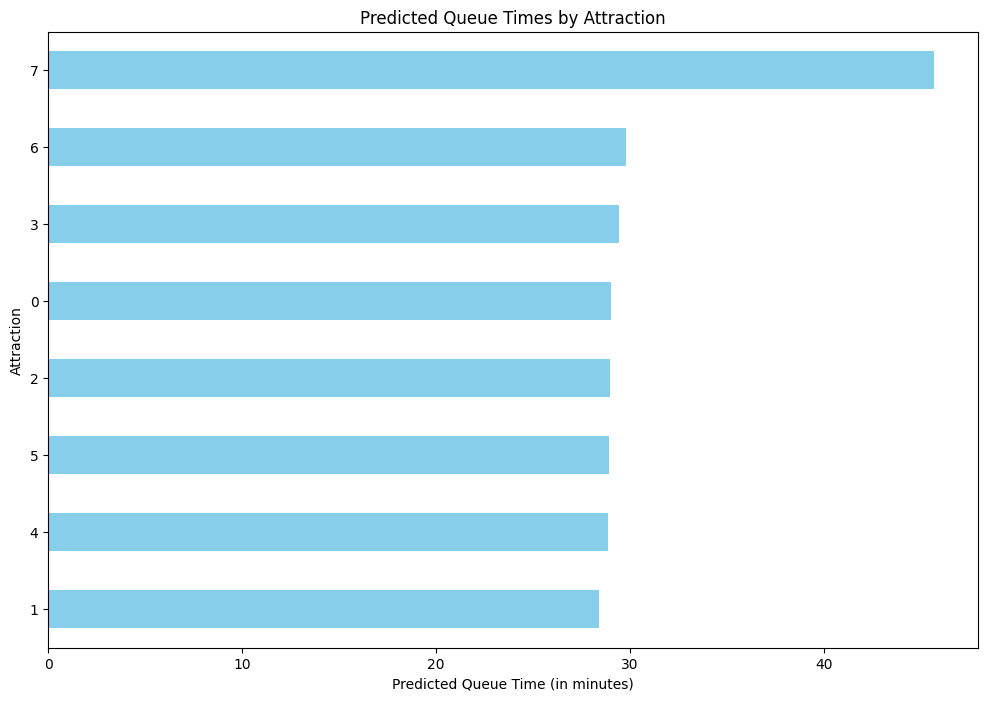

In [29]:
model_2, metrics_2 = train_demand_model(df_all_combined_processed)

### XGBoost Modelling specifically for IoT Data only

Cross-validation negative MSE scores: [-49.94457138 -50.96486581 -51.29895363 -51.38191435 -54.60583989]
Mean cross-validation score: -51.639229010344636
Model trained successfully.
RMSE: 6.4316
MAE: 4.8099


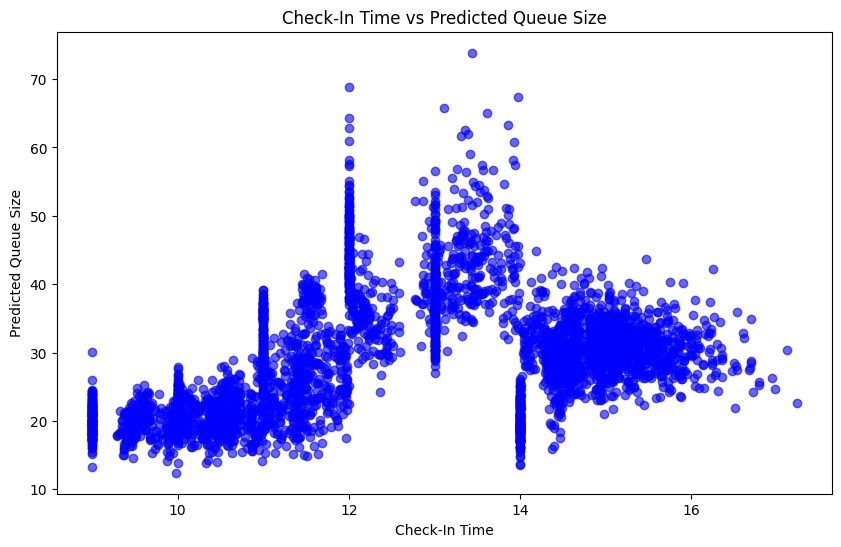

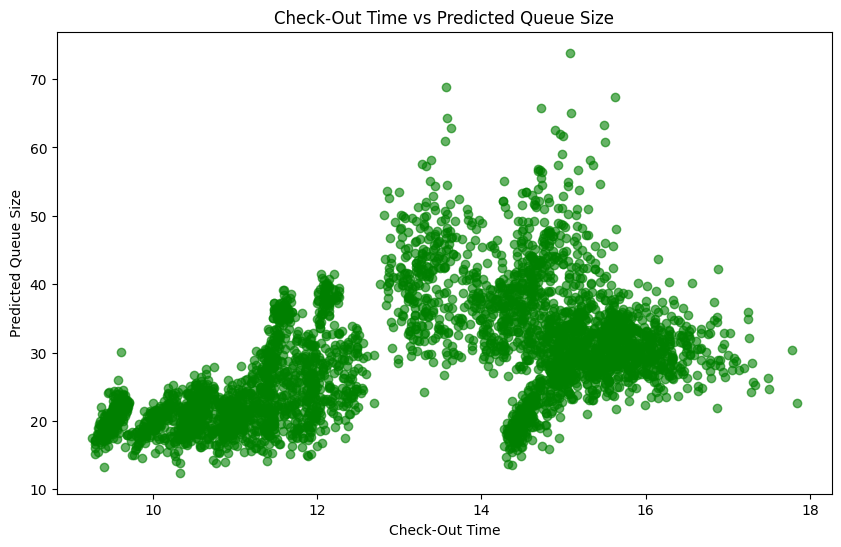


Correlation with Predicted Avg_Wait_Time:
Predicted_Avg_Wait_Time    1.000000
Queue_Time                 0.721305
Check_Out                  0.503360
Check_In                   0.399232
Is_Weekend                 0.032361
Day_of_Week                0.018656
Merchandise_Spending       0.007219
Gender                     0.006196
Attraction                 0.004596
Total_Spending             0.000258
Loyalty_Member            -0.005798
Visitor_ID                -0.010721
Is_Popular_Attraction     -0.018627
Restaurant_Spending       -0.021728
Theme_Zone_Visited        -0.022662
Age                       -0.047530
Name: Predicted_Avg_Wait_Time, dtype: float64


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

def train_demand_model_2(df, target='Avg_Wait_Time'):
    """
    Trains an XGBoost model on the given dataset and returns evaluation metrics.
    
    Args:
        df (pd.DataFrame): Dataset to train the model on.
        target (str): The target column to predict (default: 'Avg_Wait_Time').
    
    Returns:
        model (XGBRegressor): The trained XGBoost model.
        metrics (dict): Evaluation metrics of the model.
    """
    # Define feature columns based on the dataset
    features = [
            'Visitor_ID', 'Loyalty_Member', 'Age', 'Gender',
            'Theme_Zone_Visited', 'Attraction', 'Check_In', 'Queue_Time', 'Check_Out', 'Restaurant_Spending',
            'Merchandise_Spending', 'Total_Spending', 'Day_of_Week', 'Is_Weekend', 'Is_Popular_Attraction'
        ]
    df = df[features + [target]]
    
    # Encode categorical columns
    label_cols = ['Favorite_Attraction', 'Age_Group', 'Employment_Status', 'Visit_Quarter', 
                  'Event', 'Attraction_Reason', 'Season', 'Day_of_Week', 'Visitor_ID', 'Attraction']
    
    for col in label_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # Define features and target
    X = df[features]
    y = df[target]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize XGBoost model
    model = XGBRegressor(
        random_state=42,
        n_estimators=500,
        max_depth=4,
        learning_rate=0.1,
        verbosity=0
    )
    
    # Perform cross-validation to evaluate the model
    cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"Cross-validation negative MSE scores: {cross_val_scores}")
    print(f"Mean cross-validation score: {np.mean(cross_val_scores)}")

    # Fit model on training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

    print("Model trained successfully.")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")

    # Plot Check_In vs Predicted Queue
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test['Check_In'], y_pred, color='blue', alpha=0.6)
    plt.title('Check-In Time vs Predicted Queue Size')
    plt.xlabel('Check-In Time')
    plt.ylabel('Predicted Queue Size')
    plt.show()

    # Plot Check_Out vs Predicted Queue
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test['Check_Out'], y_pred, color='green', alpha=0.6)
    plt.title('Check-Out Time vs Predicted Queue Size')
    plt.xlabel('Check-Out Time')
    plt.ylabel('Predicted Queue Size')
    plt.show()

    # Create a DataFrame with predicted values and features from X_test
    df_test = X_test.copy()
    df_test['Predicted_' + target] = y_pred

     # Calculate correlation between predicted values and features
    correlation = df_test.corr()['Predicted_' + target].sort_values(ascending=False)

    print("\nCorrelation with Predicted " + target + ":")
    print(correlation)

    return model, metrics

# Example usage:
# Assuming df_all_combined_processed is your dataset (merged survey + IoT or just survey)
model_1, metrics_1 = train_demand_model_2(df_iot)


## Modelling with SVR

Purpose:
Trains a Support Vector Regression (SVR) model for predicting the average wait time (or another specified target) based on various input features. The model is evaluated using standard regression metrics, and feature correlations with the predicted queue size are provided for insight.

Arguments:
df (pd.DataFrame): The input dataset containing both the features and the target variable. The dataset can either be a survey-only dataset or one with detailed IoT data.

target (str): The target column name for the prediction. Defaults to 'Avg_Wait_Time' but can be adjusted to another continuous column to predict, such as Avg_Queue_Time.

Returns:
model (SVR): The trained SVR (Support Vector Regression) model object.

Model Initialization: The model uses a Radial Basis Function (RBF) kernel and is initialized with C=1.0 and epsilon=0.1 for the SVR.

Model Evaluation:
Two common regression metrics are calculated: RMSE, MAE
Feature Correlation:
- The function calculates the correlation between the predicted queue size (or target) and the input features.
- This correlation helps to identify which features most influence the prediction.

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

def train_svr_model(df, target='Avg_Wait_Time'):
    """
    Trains an SVR model for demand prediction.

    Args:
        df (pd.DataFrame): The dataset to train the model.
        target (str): The target column for prediction.

    Returns:
        model (SVR): Trained SVR model.
        metrics (dict): Evaluation metrics on test data.
    """
    # Check if the target exists in the dataset
    if 'Theme_Zone_Visited' in df.columns:
        features = [
            'Favorite_Attraction', 'Satisfaction_Score', 'Age_Group', 'Employment_Status',
            'Visit_Quarter', 'Event', 'Attraction_Reason', 'Season', 'rainfall', 'air_temperature',
            'relative_humidity', 'wind_speed', 'Visitor_ID', 'Loyalty_Member', 'Age', 'Gender',
            'Theme_Zone_Visited', 'Attraction', 'Check_In', 'Queue_Time', 'Check_Out', 'Restaurant_Spending',
            'Merchandise_Spending', 'Total_Spending', 'Day_of_Week', 'Is_Weekend', 'Is_Popular_Attraction',
            'Year', 'Month'
        ]
    else:
        # For survey-only data
        features = [
            'Favorite_Attraction', 'Satisfaction_Score', 'Age_Group', 'Employment_Status',
            'Visit_Quarter', 'Event', 'Attraction_Reason', 'Season', 'rainfall', 'air_temperature',
            'relative_humidity', 'wind_speed'
        ]

    # Prepare training data (X) and target (y)
    X = df[features]
    y = df[target]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the SVR model
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    
    # Train the SVR model
    model.fit(X_train, y_train)
    
    # Predict using the trained model
    y_pred = model.predict(X_test)

    # Evaluate model performance
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

    print("Model trained successfully.")
    print("Evaluation:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    # Correlation between predicted demand (queue size) and input features
    df_test = X_test.copy()
    df_test['Actual_Queue'] = y_test
    df_test['Predicted_Queue'] = y_pred

    # Calculate correlations between predicted values and features
    correlation = df_test.corr()['Predicted_Queue'].sort_values(ascending=False)
    print("\nCorrelation with Predicted Queue Size:")
    print(correlation)

    return model, metrics


### Modelling with no IoT dataset
Yields slightly better results compared to the XGBoost model, but only marginally better.

In [ ]:
model_svr_1, metrics_svr_1 = train_svr_model(df_combined_processed)

✅ Model trained successfully.
📊 Evaluation:
RMSE: 21.8033
MAE: 16.7893

Correlation with Predicted Queue Size:
Predicted_Queue        1.000000
Attraction_Reason      0.231440
rainfall               0.132657
wind_speed             0.123523
Age_Group             -0.003315
relative_humidity     -0.007318
Visit_Quarter         -0.017455
Season                -0.017455
Satisfaction_Score    -0.025793
Event                 -0.028358
Favorite_Attraction   -0.032367
Actual_Queue          -0.035258
Employment_Status     -0.063911
air_temperature       -0.071007
Name: Predicted_Queue, dtype: float64


### Modelling with IOT dataset
Evaluation shows that in general, addition of IoT data has given better predictions compared to just using the survey dataset.

In [ ]:
model_svr_2, metrics_svr_2 = train_svr_model(df_all_combined_processed)

✅ Model trained successfully.
📊 Evaluation:
RMSE: 12.4136
MAE: 9.5773

Correlation with Predicted Queue Size:
Predicted_Queue          1.000000
Attraction_Reason        0.838693
Attraction               0.322701
Actual_Queue             0.297263
Queue_Time               0.204278
Visitor_ID               0.156103
Season                   0.095818
Check_Out                0.052247
Restaurant_Spending      0.024737
Satisfaction_Score       0.022543
Check_In                 0.021528
Loyalty_Member           0.009587
Age                      0.007131
Total_Spending           0.006991
Is_Popular_Attraction    0.006414
Merchandise_Spending    -0.000598
Month                   -0.004048
Day_of_Week             -0.004688
Is_Weekend              -0.006304
Gender                  -0.008430
Theme_Zone_Visited      -0.009522
relative_humidity       -0.014820
rainfall                -0.043153
wind_speed              -0.047102
air_temperature         -0.048104
Favorite_Attraction     -0.603903
Visit_